In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

import halotools
from halotools.empirical_models import PrebuiltSubhaloModelFactory

In [2]:
import sys 
sys.path.append('MCMC/')
from functions import *

3.0rc2


In [3]:
config_directory = '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/'

config_initial = parse_config(config_directory+'mcmc_config_5.yaml')
config, cosmos_data, sim_data = initial_model(config_initial)

5SHMR+scatter


In [4]:
halo_data = sim_data['halocat'].halo_table

In [5]:
halo_data

halo_upid,halo_y,halo_x,halo_z,halo_Vmax@Mpeak,halo_rvir,halo_vy,halo_id,halo_vx,halo_mpeak,halo_vz,halo_mvir,halo_hostid,halo_mvir_host_halo
int64,float32,float32,float32,float64,float32,float32,int64,float32,float32,float32,float32,int64,float32
-1,43.1197,36.04457,18.14896,999.86,1.207201,64.9,2404371171,21.07,162700000000000.0,-118.07,162700000000000.0,2404371171,162700000000000.0
2404371171,43.78071,35.53276,18.6678,40.06,0.037709,596.8,2404371172,-12.44,6819000000.0,484.04,4959000000.0,2404371171,162700000000000.0
2404371171,43.79097,35.40477,17.89662,35.48,0.035187,215.19,2404371173,-949.14,5889000000.0,-214.14,4029000000.0,2404371171,162700000000000.0
2404371171,43.65819,35.40134,17.56539,39.84,0.031128,167.72,2404371174,-217.95,5734000000.0,-795.51,2789000000.0,2404371171,162700000000000.0
2404371171,42.74515,35.22659,18.61028,30.83,0.029292999,-681.13,2404371175,-593.36,3254000000.0,-213.05,2324000000.0,2404371171,162700000000000.0
2404371171,43.34295,35.84579,18.4178,119.86,0.022721,163.26,2404371177,377.35,73760000000.0,-1119.11,1085000000.0,2404371171,162700000000000.0
2404371171,43.06175,35.40682,18.02761,19.03,0.021583,1072.98,2404371178,957.65,1085000000.0,-633.85,929800000.0,2404371171,162700000000000.0
2404371171,43.18763,36.27704,18.30016,43.93,0.021583,-507.66,2404371179,410.62,4959000000.0,1374.05,929800000.0,2404371171,162700000000000.0
2404371171,43.62281,35.36304,18.34547,17.54,0.018855,87.78,2404371190,-620.88,929800000.0,-591.06,619900000.0,2404371171,162700000000000.0


In [10]:
sim_data['model'] = PrebuiltSubhaloModelFactory('behroozi10', redshift=config['sim_z'])


# populate mock
# sim_data['model'].populate_mock(deepcopy(sim_data['halocat']))
sim_data['model'].populate_mock(sim_data['halocat'])

In [11]:
sim_data['model'].mock.galaxy_table

halo_upid,halo_hostid,halo_mpeak,halo_x,halo_y,halo_id,halo_z,halo_vx,halo_vy,halo_vz,halo_rvir,halo_mvir,halo_mvir_host_halo,x,y,z,vx,vy,vz,galid,stellar_mass
int64,int64,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32
-1,2404371171,162700000000000.0,36.04457,43.1197,2404371171,18.14896,21.07,64.9,-118.07,1.207201,162700000000000.0,162700000000000.0,36.04457,43.1197,18.14896,21.07,64.9,-118.07,0,137801040000.0
2404371171,2404371171,6819000000.0,35.53276,43.78071,2404371172,18.6678,-12.44,596.8,484.04,0.037709,4959000000.0,162700000000000.0,35.53276,43.78071,18.6678,-12.44,596.8,484.04,1,592078.06
2404371171,2404371171,5889000000.0,35.40477,43.79097,2404371173,17.89662,-949.14,215.19,-214.14,0.035187,4029000000.0,162700000000000.0,35.40477,43.79097,17.89662,-949.14,215.19,-214.14,2,436996.2
2404371171,2404371171,5734000000.0,35.40134,43.65819,2404371174,17.56539,-217.95,167.72,-795.51,0.031128,2789000000.0,162700000000000.0,35.40134,43.65819,17.56539,-217.95,167.72,-795.51,3,70071.82
2404371171,2404371171,3254000000.0,35.22659,42.74515,2404371175,18.61028,-593.36,-681.13,-213.05,0.029292999,2324000000.0,162700000000000.0,35.22659,42.74515,18.61028,-593.36,-681.13,-213.05,4,186992.77
2404371171,2404371171,73760000000.0,35.84579,43.34295,2404371177,18.4178,377.35,163.26,-1119.11,0.022721,1085000000.0,162700000000000.0,35.84579,43.34295,18.4178,377.35,163.26,-1119.11,5,103285770.0
2404371171,2404371171,1085000000.0,35.40682,43.06175,2404371178,18.02761,957.65,1072.98,-633.85,0.021583,929800000.0,162700000000000.0,35.40682,43.06175,18.02761,957.65,1072.98,-633.85,6,3966.594
2404371171,2404371171,4959000000.0,36.27704,43.18763,2404371179,18.30016,410.62,-507.66,1374.05,0.021583,929800000.0,162700000000000.0,36.27704,43.18763,18.30016,410.62,-507.66,1374.05,7,329647.94
2404371171,2404371171,929800000.0,35.36304,43.62281,2404371190,18.34547,-620.88,87.78,-591.06,0.018855,619900000.0,162700000000000.0,35.36304,43.62281,18.34547,-620.88,87.78,-591.06,8,1487.2104


# Chris code

In [13]:
# Given a list of halo masses, find the expected stellar mass
# Does this by guessing stellar masses and plugging them into the inverse
# Scipy is so sick . . .
def f_shmr(log_halo_masses, m1, sm0, beta, delta, gamma):
    if np.max(log_halo_masses) > 1e6:
        raise Exception("You are probably not passing log halo masses!")
    # Function to minimize
    def f(stellar_masses_guess):
        return np.sum(
                np.power(
                    f_shmr_inverse(stellar_masses_guess, m1, sm0, beta, delta, gamma) - log_halo_masses,
                    2,
                )
        )
    # Gradient of the function to minimize
    def f_der(stellar_masses_guess):
        return 2 * (
                (f_shmr_inverse(stellar_masses_guess, m1, sm0, beta, delta, gamma) - log_halo_masses) *
                f_shmr_inverse_der(stellar_masses_guess, sm0, beta, delta, gamma)
        )

    x = scipy.optimize.minimize(
            f,
            log_halo_masses - 2,
            method="CG",
            jac=f_der,
            tol=1e-12, # roughly seems to be as far as we go without loss of precision
    )
    if not x.success:
        raise Exception("Failure to invert {}".format(x.message))
    return x.x
def f_shmr_inverse(log_stellar_masses, m1, sm0, beta, delta, gamma):
    if np.max(log_stellar_masses) > 1e6:
        raise Exception("You are probably not passing log masses!")

    stellar_masses = np.power(10, log_stellar_masses)

    usm = stellar_masses / sm0 # unitless stellar mass is sm / characteristic mass
    log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
    return log_halo_mass

# d log10(halo_mass) / d log10(stellar_mass)
# http://www.wolframalpha.com/input/?i=d%2Fdx+B*log10(x%2FS)+%2B+((x%2FS)%5Ed)+%2F+(1+%2B+(x%2FS)%5E-g)+-+0.5
# https://math.stackexchange.com/questions/504997/derivative-with-respect-to-logx
def f_shmr_inverse_der(log_stellar_masses, sm0, beta, delta, gamma):
    if np.max(log_stellar_masses) > 1e6:
        raise Exception("You are probably not passing log masses to der!")

    stellar_masses = np.power(10, log_stellar_masses)
    usm = stellar_masses / sm0 # unitless stellar mass is sm / characteristic mass
    denom = (usm**-gamma) + 1
    return stellar_masses * np.log(10) * (
        (beta / (stellar_masses * np.log(10))) +
        ((delta * np.power(usm, delta - 1)) / (sm0 * denom)) +
        ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))






# Given the b_params for the behroozi functional form, and the halos in the sim
# find the SM for each halo
def get_sm_for_sim(sim_data, b_params, s_params, x_field, sanity=False):
    assert len(b_params) == 5 and len(s_params) == 2

    log_halo_masses = np.log10(sim_data[x_field])
    min_mvir = np.min(log_halo_masses)
    max_mvir = np.max(log_halo_masses)

    sample_halo_masses = np.linspace(min_mvir, max_mvir, num=12)

    try:
        sample_stellar_masses = f_shmr(
            sample_halo_masses,
            10**b_params[0],
            10**b_params[1],
            *b_params[2:])
        
    except Exception as e:
        if e.args[0].startswith("Failure to invert"):
            return np.zeros_like(log_halo_masses)
        raise


    f_mvir_to_sm = scipy.interpolate.interp1d(sample_halo_masses, sample_stellar_masses)

    log_stellar_masses = f_mvir_to_sm(log_halo_masses)
    if not np.all(np.isfinite(log_stellar_masses)):
        print("infinite SM")
        return np.zeros_like(log_stellar_masses)

    # This adds some stochasticity... Ideally we would keep these as a distribution
    # But that is much harder. So we just accept the stochasticity and that the MCMC
    # will take longer to converge

    log_sm_scatter = s_params[0] * log_halo_masses + s_params[1]
    if not np.all(log_sm_scatter > 0):
        print("negative scatter")
        return np.zeros_like(log_stellar_masses)

    log_stellar_masses += np.random.normal(0, log_sm_scatter, size=len(log_sm_scatter))

    if sanity:
        return log_stellar_masses, sample_halo_masses, sample_stellar_masses, f_mvir_to_sm, min_mvir, max_mvir
    else:
        return log_stellar_masses

In [14]:
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
# mass_s_params = [-0.06, 1.08] #chris params
mass_s_params = [-0.2/3., 1.2]  #felipe params
mass_x_field = "halo_mvir"

In [15]:
chris_stellar_masses = get_sm_for_sim(halo_data, mass_b_params, mass_s_params, mass_x_field, sanity=False)

# HALOTOOLS 

In [16]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory

In [17]:
params = mass_s_params + mass_b_params #concatenate
params = [0.4,0.2]+mass_b_params

In [18]:
sim_data['model'] = PrebuiltSubhaloModelFactory('behroozi10', redshift=config['sim_z'],
                                        scatter_abscissa=[12, 15],
                                        scatter_ordinates=[params[0], params[1]])

for i, model_param in enumerate(config['param_labels']):
    sim_data['model'].param_dict[model_param] = params[i]

# set redshift dependence to 0
for i, model_param in enumerate(config['redshift_param_labels']):
    sim_data['model'].param_dict[model_param] = 0

# populate mock
# sim_data['model'].populate_mock(deepcopy(sim_data['halocat']))
sim_data['model'].populate_mock(sim_data['halocat'])

mock_galaxies = sim_data['model'].mock.galaxy_table
mock_galaxies = mock_galaxies['x', 'y', 'z', 'stellar_mass']

In [19]:
halotools_stellar_masses = np.log10(mock_galaxies['stellar_mass'])

# histograms 

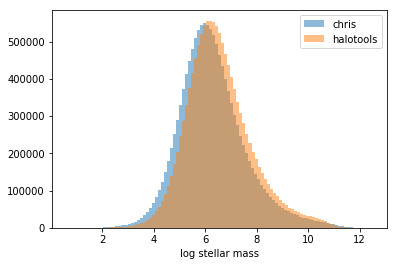

In [65]:
plt.hist(chris_stellar_masses, bins =100, alpha =0.5, label='chris')
plt.hist(halotools_stellar_masses, bins =100, alpha =0.5, label='halotools')

plt.legend()
plt.xlabel('log stellar mass')

plt.show()

In [66]:
print len(halotools_stellar_masses), len(chris_stellar_masses)

12939617 12939617


In [3]:
scatter_params = np.polyfit([12,15],[0.4,0.2],1)

In [5]:
scatter_params[0]

-0.06666666666666685

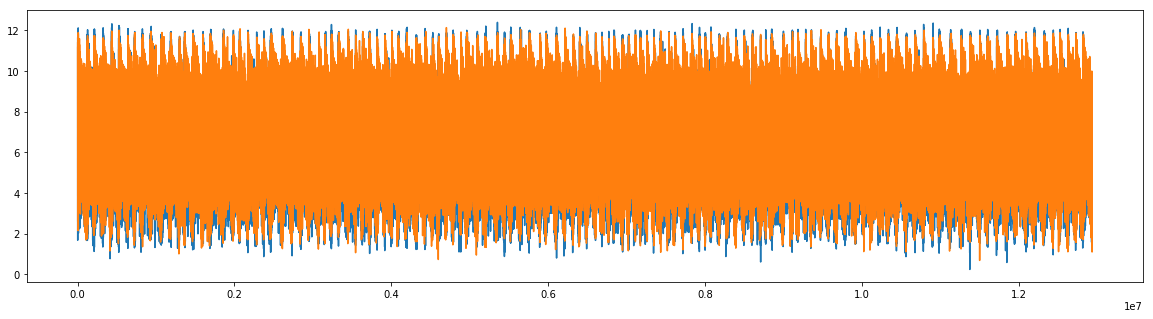

In [25]:
plt.figure(figsize=[20,5])
plt.plot(range(len(chris_stellar_masses)), chris_stellar_masses)
plt.plot(range(len(chris_stellar_masses)), halotools_stellar_masses)


In [28]:
mock_galaxies = sim_data['halocat'].halo_table['halo_x', 'halo_y', 'halo_z']
mock_galaxies['stellar_mass'] = chris_stellar_masses
mock_galaxies

halo_x,halo_y,halo_z,stellar_mass
float32,float32,float32,float64
36.04457,43.1197,18.14896,11.61379229121843
35.53276,43.78071,18.6678,5.717803842847478
35.40477,43.79097,17.89662,6.100653391039932
35.40134,43.65819,17.56539,4.4279617866960255
35.22659,42.74515,18.61028,5.54396695323049
35.84579,43.34295,18.4178,4.025752227906292
35.40682,43.06175,18.02761,3.260047561288997
36.27704,43.18763,18.30016,4.504874723632895
35.36304,43.62281,18.34547,3.515351158357194


In [30]:
sim_data['model'].mock.Lbox

array([250., 250., 250.])